## Kosten van uniforme doorsnede-eisen
Een belangrijke vraag bij het ontwerp is de verdeling van doorsnede-eisen over de mechanismen.
In dit notebook kijken we naar de kosten van verschillende ontwerpeisen, waarbij we de ontwerpeisen uniform houden per dijkvak. 
Dat geeft inzicht in:
* Wat optimale (uniforme/top-down) eisen zijn voor het traject
* Wat de eventuele meerwaarde is van het varieren van eisen over mechanismen en vakken (conform veiligheidsrendement)

We kijken hiervoor naar traject 10-1, op basis van LBO-1, maar zonder lengte-effect.

In [13]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn
import itertools
from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from scripts.postprocessing.database_analytics import *
from scripts.postprocessing.database_access_functions import *
from scripts.postprocessing.generate_output import *
from vrtool.probabilistic_tools.probabilistic_functions import beta_to_pf, pf_to_beta

import matplotlib.pyplot as plt

class Deltares_colors:
    '''
    See bottom for implementation example
    '''

    def __init__(self):

         self.colors = {'zwart' : '#000000',
                        'blauw1' : '#080c80',
                        'blauw2' : '#0d38e0',
                        'blauw3' : '#0ebbf0',
                        'groen1' : '#00b389',
                        'groen2' : '#00cc96',
                        'groen3' : '#00e6a1',
                        'grijs1' : '#f2f2f2',
                        'grijs2' : '#e6e6e6',
                        'geel' : '#ffd814',
                        'academy' : '#ff960d'
                       }

         self.colorlist = {'DeltaresDefault'    : [self.colors[c] for c in ['blauw1', 'blauw2', 'blauw3', 'groen1', 'groen2', 'groen3' ]],
                          'DeltaresFull'       : [self.colors[c] for c in ['blauw1', 'blauw2', 'blauw3', 'groen1', 'groen2', 'groen3', 'academy', 'geel', 'grijs2', 'zwart' ]],
                          'DeltaresBlues'      : [self.colors[c] for c in ['blauw1', 'blauw2', 'blauw3' ]],
                          'DeltaresBlues_r'    : [self.colors[c] for c in ['blauw3', 'blauw2', 'blauw1' ]],
                          'DeltaresGreens'     : [self.colors[c] for c in ['groen1', 'groen2', 'groen3' ]],
                          'DeltaresGreens_r'   : [self.colors[c] for c in ['groen3', 'groen2', 'groen1' ]],
                          'DeltaresOranges'    : [self.colors[c] for c in ['academy', 'geel', 'grijs2' ]],
                          'DeltaresOranges_r'  : [self.colors[c] for c in ['grijs2', 'geel', 'academy' ]]
                          }

    def sns_palette(self, colorlist_name):
        '''
        :param colorlist_name: str, colorlist name in Deltares_colors.colorlist set
        '''

        if colorlist_name not in self.colorlist.keys():
            raise Exception('Colorlist not defined in Deltares color palette')

        cp = sns.color_palette(self.colorlist[colorlist_name])

        return cp


    def sns_sequential(self, color_name, shade='light', reverse=False, ncolors=None ):
        '''
        :param color_name: str, color name in Deltares_colors.colors set
        :param shade: str, options: 'light' or 'dark' palette
        :param reverse: boolean, to reverse the palette
        :param ncolors: int, number of colors in colormap, if None then a colormap is returned
        '''

        if color_name not in self.colors.keys():
            raise Exception('Color name not defined in Deltares color palette')

        if ncolors == None:
            cmap_bool=True
        else:
            cmap_bool = False

        if shade == 'dark':
            cp = sns.dark_palette(self.colors[color_name], as_cmap=cmap_bool, reverse=reverse, n_colors=ncolors)
        elif shade == 'light':
            cp = sns.light_palette(self.colors[color_name], as_cmap=cmap_bool, reverse=reverse, n_colors=ncolors)

        return cp

sns.set(style="whitegrid")
colors =  Deltares_colors().sns_palette("DeltaresFull")

In [14]:
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\10-1\versie 2\10-1_LBO1_metbodemdaling\database_10-1.sqlite")
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\10-1\versie 2\10-1_Trajectaanpak_metbodemdaling\database_10-1.sqlite")
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\10-1\versie 2\10-1_Trajectaanpak_metbodemdaling\lengte-effecten\database_10-1.sqlite")
db_path = Path(r"C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\41-1_database_origineel.db")
# db_path = Path(r"c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\53-1\53-1_vakindeling1.db")
has_revetment = False
# LE = True
LE = False
_runs_overview = get_overview_of_runs(db_path)

In [24]:
#VRM results
optimization_steps = get_optimization_steps_for_run_id(db_path, 1)
considered_tc_step = get_minimal_tc_step(optimization_steps)-1

lists_of_measures = get_measures_for_run_id(db_path, 1)
measures_per_step = get_measures_per_step_number(lists_of_measures)

assessment_results = {}
for mechanism in [MechanismEnum.OVERFLOW, MechanismEnum.PIPING, MechanismEnum.STABILITY_INNER, MechanismEnum.REVETMENT]:
    if has_revetment or mechanism != MechanismEnum.REVETMENT:
        assessment_results[mechanism] = import_original_assessment(db_path, mechanism)


reliability_per_step = get_reliability_for_each_step(db_path, measures_per_step)

stepwise_assessment = assessment_for_each_step(copy.deepcopy(assessment_results), reliability_per_step)

traject_probability = calculate_traject_probability_for_steps(stepwise_assessment)

def calculate_traject_probability(traject_prob):
    p_nonf = [1] * len(list(traject_prob.values())[0].values())
    for mechanism, data in traject_prob.items():
        time, pf = zip(*sorted(data.items()))
        
        p_nonf = np.multiply(p_nonf, np.subtract(1,pf))
    return time, list(1-p_nonf)

traject_probs = [calculate_traject_probability(traject_probability_step ) for traject_probability_step in traject_probability]
traject_probs

[((0, 19, 20, 25, 50, 75, 100),
  [0.09562056040494016,
   0.09606587510969489,
   0.09609719749741086,
   0.09626876542106155,
   0.09764883134543301,
   0.10075928830016645,
   0.10811136593394344]),
 ((0, 19, 20, 25, 50, 75, 100),
  [0.08314518246193636,
   0.08359659177345058,
   0.08362834210376069,
   0.08380225263832441,
   0.08520110017866478,
   0.08835374712761546,
   0.09580533648625777]),
 ((0, 19, 20, 25, 50, 75, 100),
  [0.0702644429761593,
   0.07072179115166943,
   0.07075395971480258,
   0.0709301623711075,
   0.07234752586666182,
   0.07554239633683135,
   0.0830946960716119]),
 ((0, 19, 20, 25, 50, 75, 100),
  [0.06060119650855611,
   0.061062519763030565,
   0.061094970388716585,
   0.06127272291077168,
   0.06270279145514679,
   0.06592739542070247,
   0.07355185083771532]),
 ((0, 19, 20, 25, 50, 75, 100),
  [0.039626509387599596,
   0.04005338046535811,
   0.04008368703955345,
   0.04025019547473385,
   0.04161098568360455,
   0.04475377904502431,
   0.05231444374

Now we are going to read the measures for each section, and for a grid of probabilities determine the costs associated with meeting a set of requirements for overflow, stability & piping. This grid runs from the standard to 100000 more stringent for each.

In [16]:
import pandas as pd

# Define the function to get measures for all sections
def get_measures_for_all_sections(db_path, t_design):
    # Fetch all MeasureResultMechanism records for the specified year
    measures_for_all_sections_beta = (MeasureResultMechanism
                                      .select(MeasureResultMechanism, MechanismPerSection, Mechanism.name)
                                      .join(MechanismPerSection, on=(MechanismPerSection.id == MeasureResultMechanism.mechanism_per_section_id))
                                      .join(Mechanism, on=(Mechanism.id == MechanismPerSection.mechanism_id))
                                      .where(MeasureResultMechanism.time == t_design))

    # Fetch all MeasureResultSection records for the specified year
    measures_for_all_sections_cost = (MeasureResultSection
                                      .select()
                                      .where(MeasureResultSection.time == t_design))
    
    measure_types_for_all_sections = (MeasureResult
                                      .select(MeasureResult, MeasurePerSection, Measure, MeasureType)
                                        .join(MeasurePerSection, on=(MeasurePerSection.id == MeasureResult.measure_per_section_id))
                                        .join(Measure, on=(Measure.id == MeasurePerSection.measure_id))
                                        .join(MeasureType, on=(MeasureType.id == Measure.measure_type_id)))

    # Convert the beta query results to a list of dictionaries
    beta_data_list = []
    for measure in measures_for_all_sections_beta:
        data = measure.__data__
        data['mechanism_name'] = measure.mechanism_per_section.mechanism.name
        data['section_id'] = measure.mechanism_per_section.section_id
        beta_data_list.append(data)
    
    measure_type_data_list = []
    for measure in measure_types_for_all_sections:
        data = measure.__data__
        data['measure_type_id'] = measure.measure_per_section.measure.measure_type.id
        measure_type_data_list.append(data)

    # Convert to Pandas DataFrame
    beta_df = pd.DataFrame(beta_data_list)
    beta_df.drop(columns=['id', 'mechanism_per_section'], inplace=True)
    beta_df = beta_df.pivot(index=['section_id','measure_result'], columns=['mechanism_name'], values='beta')
    #remove mechanism_name from the index
    beta_df.reset_index(inplace=True)
    beta_df.set_index('measure_result', inplace=True)
    
    # Convert the cost query results to a list of dictionaries
    cost_data_list = []
    for measure in measures_for_all_sections_cost:
        cost_data_list.append({'measure_result_id': measure.measure_result_id, 'cost': measure.cost})
    # Convert to Pandas DataFrame
    cost_df = pd.DataFrame(cost_data_list)
    cost_df.set_index('measure_result_id', inplace=True)
    
    #measure type list
    measure_type_data = pd.DataFrame(measure_type_data_list)[['id', 'measure_type_id']].rename(columns={'id':'measure_result'})
    measure_type_data.drop_duplicates(inplace=True)
    df = beta_df.join(measure_type_data.set_index('measure_result'))
    # Join the beta and cost DataFrames
    df = df.join(cost_df)
    
    return df

t_design = 50
measures_df_db = get_measures_for_all_sections(db_path, t_design)

In [17]:
#now we want to add grond+vzg for all sections as otherwise the comparison is unfair

def add_combined_vzg_soil(df):
    #copy original dataframe
    df_out = df.copy()
    for section in df.section_id.unique():
        #we get all soil reinforcements (all measures with measure_type_id 1) and make a new df of it. Make sur it is a copy
        soil = df[(df.section_id == section) & (df.measure_type_id == 1)].copy()
        vzg = df[(df.section_id == section) & (df.measure_type_id == 3)].copy()
        soil.loc[:,'cost'] = np.add(soil.cost, vzg['cost'].values[0])

        beta_piping = soil.Piping
        new_beta_piping = pf_to_beta(beta_to_pf(beta_piping)/1000.)
        soil.loc[:,'Piping'] = new_beta_piping
        soil.loc[:,'measure_type_id'] = 99
        df_out = pd.concat([df_out, soil])
    return df_out

measures_df = add_combined_vzg_soil(measures_df_db)
#sort measures_df by section_id and measure_result
measures_df.sort_values(by=['section_id', 'measure_result'], inplace=True)

#as probabilities in the df are to be interpreted as probabilities per section, we need to also compute the corresponding cross section probabilities

#get the section lengths from the database
section_lengths = pd.DataFrame([(section.id, section.section_length) for section in SectionData.select()],columns= ['section_id', 'section_length'])
section_lengths.set_index('section_id', inplace=True)
#merge lengths to measures_df
measures_df_with_dsn = measures_df.merge(section_lengths, left_on='section_id', right_index=True)
measures_df_with_dsn['Overflow_dsn'] = measures_df_with_dsn['Overflow']
if LE:
    N_piping = measures_df_with_dsn['section_length'] / 300
    N_piping = N_piping.apply(lambda x: max(x, 1))
    measures_df_with_dsn['Piping_dsn'] = pf_to_beta(beta_to_pf(measures_df_with_dsn['Piping']) / N_piping)
    N_stability = measures_df_with_dsn['section_length'] / 50
    N_stability = N_stability.apply(lambda x: max(x, 1))
    measures_df_with_dsn['StabilityInner_dsn'] = pf_to_beta(beta_to_pf(measures_df_with_dsn['StabilityInner']) / N_stability)
else:
    measures_df_with_dsn['Piping_dsn'] = measures_df_with_dsn['Piping']
    measures_df_with_dsn['StabilityInner_dsn'] = measures_df_with_dsn['StabilityInner']
measures_df_with_dsn.head()


,section_id,Overflow,Piping,StabilityInner,measure_type_id,cost,section_length,Overflow_dsn,Piping_dsn,StabilityInner_dsn
measure_result,,,,,,,,,,
1,1,3.624089,6.037092,5.11866,1,1.599549e+05,633.6353,3.624089,6.037092,5.11866
1,1,3.624089,7.068236,5.11866,99,3.454858e+06,633.6353,3.624089,7.068236,5.11866
2,1,3.624089,6.138818,5.76866,1,5.322790e+05,633.6353,3.624089,6.138818,5.76866
2,1,3.624089,7.155881,5.76866,99,3.827183e+06,633.6353,3.624089,7.155881,5.76866
3,1,3.624089,6.197942,6.15866,1,1.255673e+06,633.6353,3.624089,6.197942,6.15866


In [18]:
#get the Pmax from DikeTrajectInfo
p_max = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).p_max * 0.52
omega_piping = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).omega_piping
omega_stability_inner = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).omega_stability_inner
omega_overflow = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).omega_overflow
a_piping = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).a_piping
a_stability_inner = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).a_stability_inner
b_stability_inner = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).b_stability_inner
b_piping = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).b_piping
traject_length = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_length

#make a N based grid
# N_omega = [2., 3., 4., 5., 7., 10., 15., 25., 50.]
# N_LE = [5., 10., 20., 30., 40., 50.]

#smaller grid
N_omega = [2., 4., 8., 16., 32.]
N_LE = [5., 10., 20., 40., 50.]

N_overflow_grid = N_omega.copy()
N_piping_grid = sorted(set([a*b for a,b in list(itertools.product(N_omega, N_LE))]))
N_stability_inner_grid = sorted(set([a*b for a,b in list(itertools.product(N_omega, N_LE))]))

#add existing values:
N_overflow_grid = N_overflow_grid + [np.divide(1, omega_overflow)]
N_piping_grid = N_piping_grid + [np.divide(1,omega_piping) * np.divide(a_piping * traject_length, b_piping )]
N_stability_inner_grid = N_stability_inner_grid + [np.divide(1,omega_stability_inner) * np.divide(a_stability_inner * traject_length, b_stability_inner)]

#make a beta_grid for all
overflow_grid = pf_to_beta(np.divide(p_max, N_overflow_grid))
piping_grid = pf_to_beta(np.divide(p_max, N_piping_grid))
stability_inner_grid = pf_to_beta(np.divide(p_max, N_stability_inner_grid))
                                  
# #make a grid for all 3 mechanisms. 
target_beta_grid = itertools.product(overflow_grid, piping_grid, stability_inner_grid)
print(f"Grid dimensions are {len(overflow_grid)} x {len(piping_grid)} x {len(stability_inner_grid)}")

Grid dimensions are 6 x 14 x 14


In [19]:
def compute_traject_probability(minimal_cost_dataset):
    #no upscaling in sections. 
    pf_overflow = max(beta_to_pf(minimal_cost_dataset['Overflow']))
    p_nonf_piping = np.product(np.subtract(1,beta_to_pf(minimal_cost_dataset['Piping'])))
    p_nonf_stability = np.product(np.subtract(1,beta_to_pf(minimal_cost_dataset['StabilityInner'])))
    pf_traject = 1- (1-pf_overflow)*(p_nonf_piping)*(p_nonf_stability)
    return pf_traject

def calculate_cost(overflow_beta, piping_beta, stability_beta, measures_df, correct_LE = False):
    #calculate the cost for the given beta values

    #get all sections
    sections = measures_df['section_id'].unique()


    possible_measures = measures_df.loc[(measures_df['Overflow_dsn'] >= overflow_beta) & 
                    (measures_df['Piping_dsn'] >= piping_beta) & 
                        (measures_df['StabilityInner_dsn'] >= stability_beta)]
    #get the minimal cost for each section_id and the betas that belong to that measure
    minimal_costs_idx = possible_measures.reset_index().groupby('section_id')['cost'].idxmin()
    minimal_costs_data = possible_measures.reset_index().loc[minimal_costs_idx]

    computed_traject_probability = compute_traject_probability(minimal_costs_data)

    minimal_costs = minimal_costs_data['cost']
    #check if all sections are in the minimal_costs, if any of them is not in there return 1e99, else return the sum of the costs
    if len(sections) != len(minimal_costs):
        return 1e99, computed_traject_probability
    else:
        return minimal_costs.sum(), computed_traject_probability


cost = []
pf_traject = []
for count, (overflow_beta, piping_beta, stability_beta) in enumerate(list(copy.deepcopy(target_beta_grid))):
    cost_i, pf_traject_i = calculate_cost(overflow_beta, piping_beta, stability_beta, measures_df_with_dsn)
    if cost_i < 1.e99:
        cost.append(cost_i)
        pf_traject.append(pf_traject_i)
    else:
        pass
        # print(f"Skipping beta combination {overflow_beta, piping_beta, stability_beta}")


In [20]:
#find the indices in the optimization steps where the total_risk is the same as the step before
risk_decrease = np.abs(np.diff([optimization_steps[i]['total_risk'] for i in range(len(traject_probs))]))
cost_increase = np.diff([optimization_steps[i]['total_lcc'] for i in range(len(traject_probs))])

#VRM
#find index where traject_probs[0][0] == 50
ind_2075 = np.where(np.array(traject_probs[0][0]) ==50)[0][0]
pf_2075 = [traject_probs[i][1][ind_2075] for i in range(len(traject_probs))]
cost_vrm = [optimization_steps[i]['total_lcc'] for i in range(len(traject_probs))]

#get indices of measures with a BC lower than 0.8 (1 and some tolerance)
BC_ratio = risk_decrease/cost_increase
low_bc_idx = np.where(BC_ratio < 1.0)[0] + 1

#remove the elements in idx_out as they are not effective
pf_2075_filtered = np.delete(pf_2075, low_bc_idx)
cost_vrm_filtered = np.delete(cost_vrm, low_bc_idx)


#compare original and new length
print(f'Original length: {len(pf_2075)} and new length: {len(pf_2075_filtered)}')

#DSN-eisen eindpunt:
if db_path.parent == Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\10-1\versie 2\10-1_Trajectaanpak_metbodemdaling'):
    pf_dsn = 3.55e-4
    cost_dsn = 81.86e6
elif db_path.parent == Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\38-1'):
    pf_dsn = 0.000016
    cost_dsn = 3.424034e+08
else:#point out of graph
    print('Doorsnede-eisen niet gegeven')
    pf_dsn = p_max
    cost_dsn = -5

Original length: 253 and new length: 163
Doorsnede-eisen niet gegeven


C:\Users\hauth\AppData\Local\Temp\ipykernel_4544\2992555447.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{x/1e6:.0f}' for x in ax.get_xticks()]);


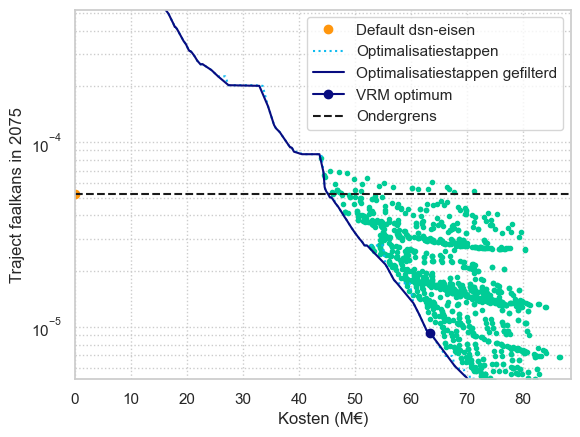

In [23]:
fig,ax = plt.subplots()
ax.scatter(cost, pf_traject, color = colors[4], marker = '.')
# ax.plot(85858728.5666441, 5e-4, 'go')
#10-1 trajectaanpak
# ax.plot(62e6, 0.0002984669659441552, 'go', label='VRM optimaal')
ax.plot(cost_dsn, pf_dsn, color = colors[6], marker = 'o', linestyle = '', label= 'Default dsn-eisen')
ax.plot(cost_vrm, pf_2075, color=colors[2], linestyle = ':', label = 'Optimalisatiestappen')
ax.plot(cost_vrm_filtered, pf_2075_filtered, color=colors[0], label = 'Optimalisatiestappen gefilterd')
ax.plot(optimization_steps[considered_tc_step-1]['total_lcc'], traject_probs[considered_tc_step-1][1][ind_2075], marker = 'o',color = colors[0], label='VRM optimum')
ax.set_xlim(left = 0, right = max(cost))
ax.hlines(p_max, 0, 5e8, colors='k', linestyles='dashed', label='Ondergrens')
ax.set_ylim(top=p_max *10,  bottom = p_max/10)
ax.set_xlabel('Kosten (M€)')
ax.set_ylabel('Traject faalkans in 2075')
ax.set_yscale('log')
ax.legend(loc = 'upper right')
#get xtick labels and divide by 1e6 and replace
ax.set_xticklabels([f'{x/1e6:.0f}' for x in ax.get_xticks()]);
ax.grid(True, which='both', linestyle=':')

#save the figure
save_dir = Path(r'C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation')
plt.savefig(save_dir.joinpath('38-1_geenLE_smaller_grid.png'), dpi=300, bbox_inches='tight')


#add veiligheidsrendement

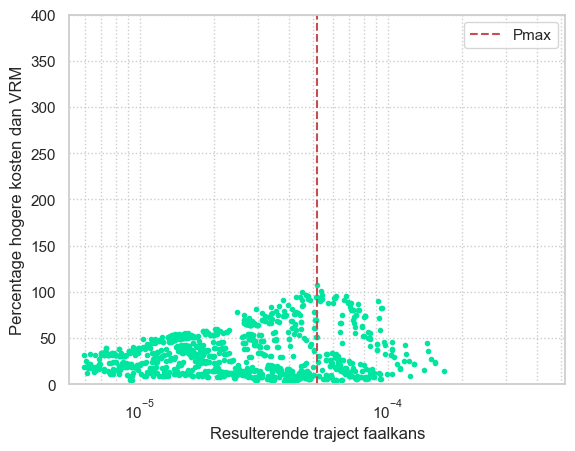

In [ ]:
#make interpolation for cost_vrm and pf_vrm
from scipy.interpolate import interp1d
f = interp1d(pf_2075, cost_vrm, bounds_error = False, fill_value = np.nan)

#for each cost, pf_traject combination, calculate the vrm cost and return the procentual difference
comparable_vrm_costs = f(pf_traject)
# factor_difference = np.divide(cost, comparable_vrm_costs)
procentual_difference = np.divide(np.subtract(cost, comparable_vrm_costs), comparable_vrm_costs)*100

fig,ax = plt.subplots()
ax.scatter(pf_traject, procentual_difference, color = colors[5], marker = '.')
ax.set_xscale('log')
ax.set_ylabel('Percentage hogere kosten dan VRM')
ax.set_xlabel('Resulterende traject faalkans')
ax.set_xlim(left = p_max/10, right = p_max*10)
ax.vlines(p_max, 0, 400, colors='r', linestyles='dashed', label='Pmax')
# ax.set_yscale('log')
ax.set_ylim(bottom = 0, top = 400)
ax.grid(True, which='both', linestyle=':')
ax.legend()



In [22]:
#find the idx of the lowest cost that meets P_max
idx_satisfied = np.argwhere(np.array(pf_traject) < p_max)
idx_satisfied = idx_satisfied.flatten()
idx_lowest_cost = np.argmin(np.array(cost)[idx_satisfied])

target_beta_grid_copy = list(copy.deepcopy(target_beta_grid))
#give the grid values of this index + cost and _pf_traject
overflow_beta, piping_beta, stability_beta = np.array(target_beta_grid_copy)[idx_satisfied][idx_lowest_cost]
cost_lowest = cost[idx_satisfied[idx_lowest_cost]]
pf_lowest = pf_traject[idx_satisfied[idx_lowest_cost]]

#print all
print('Overflow beta: ', overflow_beta)
print('Piping beta: ', piping_beta)
print('Stability beta: ', stability_beta)
print('Cost: ', cost_lowest)
print('Traject probability: ', pf_lowest)
#print the factor difference between beta_to_pf of betas and p_max for each mechanism:
print('Factor verschil voor overslag: {:.2f}'.format(p_max/beta_to_pf(overflow_beta)))
print('Factor verschil voor piping: {:.2f}'.format(p_max/beta_to_pf(piping_beta)))
print('Factor verschil voor stabiliteit: {:.2f}'.format(p_max/beta_to_pf(stability_beta)))

#default factoren:
traject_length = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_length
print('Default overslag: {:.2f}'.format(1./.24))
print('Default piping: {:.2f}'.format((1./.24) *  (0.4 * traject_length / 300)))
print('Default stabiliteit: {:.2f}'.format((1./.04) *  (0.033 * traject_length / 50)))

Overflow beta:  4.205939313613331
Piping beta:  4.408685334423085
Stability beta:  4.700126800112404
Cost:  46013596.110945985
Traject probability:  5.1993311488640614e-05
Factor verschil voor overslag: 4.00
Factor verschil voor piping: 10.00
Factor verschil voor stabiliteit: 40.00
Default overslag: 4.17
Default piping: 69.85
Default stabiliteit: 207.44
